### Résumé de tâche :

**L’objectif** est : pour un prompt et deux réponses données R et R* où R* est une **« bonne réponse »**, est-ce que « R est aussi bonne que R* » ?
> ⬆️ Comparaison

Plus **précisément** : 
1. Ont-elles des points communs ?  `analyse`
2. Des différences ? `analyse`
3. Elles se complètent ? En les combinant, on obtiendrait une réponse encore meilleure ?  `génération+évaluation`



> - Analyser le problème, proposer une solution et l’implémenter.
> - Pas besoin de chercher à faire le meilleur modèle possible (ni de tester des dizaines de modèles)
> - Se Concentrer sur l’analyse du problème, la proposition d’une solution pertinente et la qualité du code Python d’implémentation de la solution.


Analyser le problème :
- Tout d'abord, comment déterminer les critères de R, notamment **R***, autrement dit, comment devrait-on subdiviser les notes de contenu.
- Dans quel aspects on peut trouver des sim. et diff.  entre R et R* ?
- Comment fusionner R et R* pour générer une nouvelle réponse.
- Comment évaluer le(s) nouvelle(s) réponse(s).

---

### 1️⃣ Importation des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import re
from nltk.tokenize import word_tokenize
from nltk import ngrams
from sentence_transformers import SentenceTransformer, util
import torch
import os
from openai import OpenAI
from getpass import getpass
import json
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


In [2]:
# importer les données
prompts_train_df = pd.read_csv('data/prompts_train.csv')
reponses_train_df = pd.read_csv('data/summaries_train.csv')

In [3]:
# vérifier la taille des données
reponses_train_df.shape

(7165, 5)

In [4]:
# vérifier les premières lignes des données pour avoir une idée de la structure
reponses_train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


---

### 2️⃣ EDA (Exploratory Data Analysis) et Ingénierie des caractéristiques

In [5]:
# obtenir le nombre de réponses uniques et de prompts uniques
unique_reponses = reponses_train_df['student_id'].nunique()
unique_prompts = reponses_train_df['prompt_id'].nunique()

# obtenir les données statistiques descriptives sur les scores de "content".
score_stats = reponses_train_df['content'].describe()
print('réponses uniques:', unique_reponses)
print('prompts uniques:', unique_prompts)
print('*'*90)
print('Statistiques de score de content :')
print(score_stats)
print('*'*90)

réponses uniques: 7165
prompts uniques: 4
******************************************************************************************
Statistiques de score de content :
count    7165.000000
mean       -0.014853
std         1.043569
min        -1.729859
25%        -0.799545
50%        -0.093814
75%         0.499660
max         3.900326
Name: content, dtype: float64
******************************************************************************************


🔍 Un grand nombre d'élèves ont des scores négatifs.
🔍 Une diversité de réponses en termes de qualité de contenu.

---

On va ensuite effectuer les opérations suivantes sur les deux DataFrames `prompt_train_df` et `reponses_train_df`:
1. Fusionner les 2 dfs et faire certains prétraitement
2. Supprimer la colonne "wording"
3. Ajouter d'autres caractéristiques

In [6]:
# fusionner
merged_df = reponses_train_df.merge(prompts_train_df[['prompt_id', 'prompt_text','prompt_question']], on='prompt_id', how='left')


# rendre it lower 
merged_df = merged_df.apply(lambda s: s.lower() if type(s) == str else s)

# s'assurer que tout ce qui doit être str soit str
merged_df["text"]=[str(data) for data in merged_df.text] 
merged_df["prompt_text"]=[str(data) for data in merged_df.prompt_text] 

# éliminer les ponctuations
# merged_df["text"]=merged_df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
# merged_df["prompt_text"]=merged_df.prompt_text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
# Les ponctuations sont parfois utiles pour identifier les citations dans une réponse.


# supprimer wording score
merged_df = merged_df.drop(columns=['wording'])

In [7]:
merged_df.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure..."
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure..."
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...


In [8]:
# Découvrir d'autres caractéristiques

In [9]:
# Ajout de nouvelles fonctions pour explorer caractéristiques

def feature_engineering(df):
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # calculer la longueur de chaque réponse
    def compte_texte_longueur(df, col, tokenizer):
        longueur_col = df[col].apply(lambda x: len(tokenizer.encode(x)))
        return longueur_col
    
    # fonction pour calculer la similarité sémantique entre une réponse et son prompt texte
    def sim_semantique(ligne, model, prompt_embeddings):
        prompt_vecteur = prompt_embeddings[ligne['prompt_id']]
        reponse_vecteur = model.encode(ligne['text'], batch_size=1, show_progress_bar=False)
        return util.cos_sim([prompt_vecteur], [reponse_vecteur]).item()
    

    def citation_count(ligne):
        reponse = ligne['text']
        text    = ligne['prompt_text']
        cite_dans_rep = re.findall(r'"([^"]*)"', reponse)
        return [citation in text for citation in cite_dans_rep].count(True)
    
    
    def word_ngram_chevauchement(ligne, n):
        prompt_tokens = ligne['prompt_text'].split()
        reponse_tokens = ligne['text'].split()

        prompt_ngrams = set(ngrams(prompt_tokens, n))
        reponse_ngrams = set(ngrams(reponse_tokens, n))
        
        common_ngrams = prompt_ngrams.intersection(reponse_ngrams)
        
        return len(common_ngrams) / len(reponse_ngrams) if len(reponse_ngrams) else 0, len(common_ngrams)

    
    # ensuite, on les exécuter
    
    df['reponse_longueur'] = compte_texte_longueur(df, 'text',tokenizer)
    df['prompt_longueur'] = compte_texte_longueur(df, 'prompt_text',tokenizer)
    df['rep/prompt_ratio'] = df['reponse_longueur'] / df['prompt_longueur']
    
    df['vocabulaire_taille'] = df['text'].apply(lambda x: len(set(x.split())))
    df['unigram_overlap'] = df.apply(lambda row: len(set(row['prompt_text'].split()) & set(row['text'].split())), axis=1)
    df['bigram_overlap']  = df.apply(lambda x: word_ngram_chevauchement(x,2)[1], axis=1 )
    df['trigram_overlap'] = df.apply(lambda x: word_ngram_chevauchement(x,3)[1], axis=1 )
    
    df['citation'] = df.apply(citation_count, axis=1)    
    df['jaccard_similarité'] = df.apply(lambda row: len(set(word_tokenize(row['prompt_text'])) & set(word_tokenize(row['text']))) / len(set(word_tokenize(row['prompt_text'])) | set(word_tokenize(row['text']))), axis=1)
    
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embeddings_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1', device=device)
    prompt_to_emb_dict = df.groupby('prompt_id')['prompt_text'].first().transform(lambda x: embeddings_model.encode(x, batch_size=1, show_progress_bar=False)).to_dict()
    df['similarité_sémantique'] = df.apply(lambda row: sim_semantique(row, embeddings_model, prompt_to_emb_dict), axis=1)

    return df


In [10]:
merged_df_featured = feature_engineering(merged_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/xiaohua/opt/anaconda3/envs/macrun/lib/python3.9/site-packages/sent

In [11]:
merged_df_featured.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,71,673,0.105498,51,21,2,0,0,0.076190,0.659943
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,58,1175,0.049362,38,31,18,8,0,0.085427,0.495908
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",289,659,0.438543,149,65,30,9,2,0.211640,0.784489
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",41,659,0.062215,19,13,5,4,0,0.047468,0.575283
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,263,673,0.390788,138,46,20,4,4,0.142857,0.752955


In [12]:
# garder en csv
merged_df_featured.to_csv('data/merged_df_featured.csv', index=False)


---

## 3️⃣ Étudier les corrélations des features

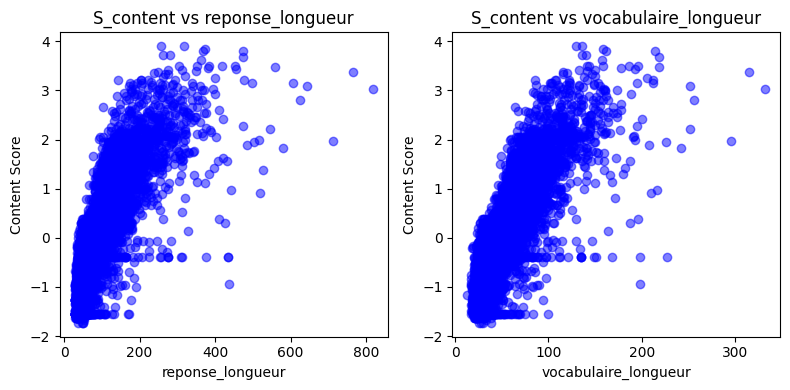

(0.7830246843816084, 0.806766673766287)

In [13]:
# Une première visualisation


# Configuration de la figure et des axes pour deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), dpi=100)

# Graphique pour le score et la longueur de réponse
ax1.scatter(merged_df_featured['reponse_longueur'], merged_df_featured['content'], alpha=0.5, color='blue')
ax1.set_title('S_content vs reponse_longueur')
ax1.set_xlabel('reponse_longueur')
ax1.set_ylabel('Content Score')

# Graphique pour le score et le nombre de mots uniques
ax2.scatter(merged_df_featured['vocabulaire_taille'], merged_df_featured['content'], alpha=0.5, color='blue')
ax2.set_title('S_content vs vocabulaire_longueur')
ax2.set_xlabel('vocabulaire_longueur')
ax2.set_ylabel('Content Score')


plt.tight_layout()
plt.show()

# Calcul de la corrélation
word_count_content_corr = merged_df_featured['reponse_longueur'].corr(merged_df_featured['content'])
vocabulary_richness_corr = merged_df_featured['vocabulaire_taille'].corr(merged_df_featured['content'])


(word_count_content_corr, vocabulary_richness_corr)

1. Une corrélation positive évidente
2. La quantité de mots uniques utilisés a un impact plus important sur le score de contenu que la simple longueur du texte

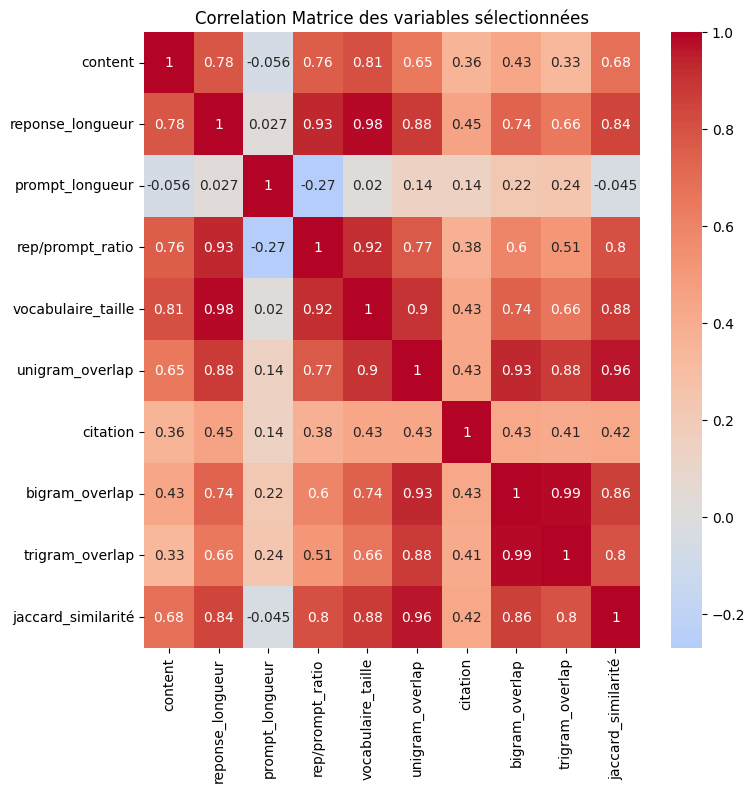

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
selected_vars = ['content', 'reponse_longueur', 'prompt_longueur', 'rep/prompt_ratio', 'vocabulaire_taille', 'unigram_overlap', 'citation', 'bigram_overlap', 'trigram_overlap', 'jaccard_similarité']

subset_df = merged_df_featured[selected_vars]

# Calculer le correlation matrice
correlation_matrice = subset_df.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(correlation_matrice, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrice des variables sélectionnées")
plt.show()

---

## 4️⃣ Définir le R et R*

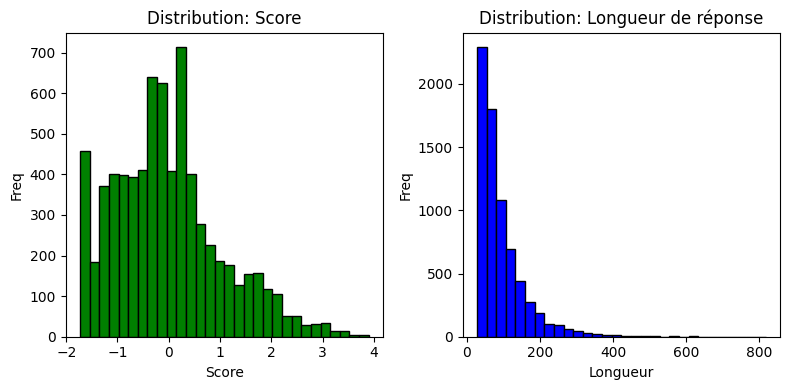

In [15]:
# un peu de visualisation pour la distribution des data
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plotting histograms
ax[0].hist(reponses_train_df['content'], bins=30, color='green', edgecolor='black')
ax[0].set_title('Distribution: Score')
ax[0].set_xlabel('Score')
ax[0].set_ylabel('Freq')

ax[1].hist(merged_df_featured['reponse_longueur'], bins=30, color='blue', edgecolor='black')
ax[1].set_title('Distribution: Longueur de réponse')
ax[1].set_xlabel('Longueur')
ax[1].set_ylabel('Freq')

# Adjusting the layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()

**Distribution du score:** légèrement asymétrique à gauche, mais globalement une distribution normale avec un pic légèrement inférieur à zéro.

**Distribution du nombre de mots dans les résumés:** Fortement asymétrique. La plupart des résumés contiennent un nombre relativement faible de mots.

---
**Pour évaluer la qualité d'une réponse, nous pouvons diviser l'ensemble de données comme suit :**

- Réponses de qualité inférieure :             n <= -1
- Réponses moyennes          :              -1 < n < 1
- Bonnes réponses         :                1 <= n <= 3
- Réponses excellentes      :                    n > 3


In [16]:
def categoriser_score(n):
    if n <= 0:
        return 'mauvais'
    elif n <= 1:
        return 'moyen'
    elif n <= 3:
        return 'bon'
    else: # n > 3
        return 'excellent'

# Appliquer cette fonction et créer une nouvelle colonne 'quality_category'
merged_df_featured['cat'] = merged_df_featured['content'].apply(categoriser_score)
merged_df_featured.to_csv('data/merged_df_featured_cat.csv', index=False)


In [19]:
merged_df_featured.head()

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,71,673,0.105498,51,21,2,0,0,0.076190,0.659943,moyen
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,58,1175,0.049362,38,31,18,8,0,0.085427,0.495908,mauvais
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",289,659,0.438543,149,65,30,9,2,0.211640,0.784489,excellent
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",41,659,0.062215,19,13,5,4,0,0.047468,0.575283,mauvais
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,263,673,0.390788,138,46,20,4,4,0.142857,0.752955,excellent


In [21]:
# Comptes de chaque cat
cat_stats = merged_df_featured['cat'].value_counts()
cat_stats

cat
mauvais      4064
moyen        1948
bon          1086
excellent      67
Name: count, dtype: int64

In [23]:
# Ensuite, extraire!

# On va extraire une réponse provenant des catégories "bon" ou "excellent"
# Puis on extrait une réponse d'un élève choisi au hasard, mais sur le même prompt.


# Sélection aléatoire un enregistrement parmi les 'bon' ou les 'excellent'
good_answers_df = merged_df_featured[merged_df_featured['cat'].isin(['bon', 'excellent'])]
r_star = good_answers_df.sample(n=1)

# En fonction du prompt_id de la réponse sélectionnée, trouver une autre réponse
r_random = merged_df_featured[merged_df_featured['prompt_id'] == r_star['prompt_id'].values[0]].drop(r_star.index).sample(n=1)


# # Suppression de ces deux enregistrements du DataFrame original
# merged_df_featured = merged_df_featured.drop(r_star.index)
# merged_df_featured = merged_df_featured.drop(r_random.index)

---

## 5️⃣ Comparer les deux réponses

In [24]:
# Affichage des résultats
r_star

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
3969,8c30d85ca17f,814d6b,The third wave was an experiment that Ron Jone...,2.507522,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,293,673,0.435364,146,92,90,75,1,0.299094,0.776892,bon


In [25]:
r_random

,student_id,prompt_id,text,content,prompt_text,prompt_question,reponse_longueur,prompt_longueur,rep/prompt_ratio,vocabulaire_taille,unigram_overlap,bigram_overlap,trigram_overlap,citation,jaccard_similarité,similarité_sémantique,cat
885,1fcfc386acd8,814d6b,Once he gave control to the kids they toke it ...,-0.687288,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,33,673,0.049034,24,10,2,0,0,0.040134,0.262403,mauvais


In [26]:
# feature_extrait + similarite_cosinus
def extract_features_features(df):
    feature_columns = ['reponse_longueur', 'rep/prompt_ratio', 'vocabulaire_taille', 'unigram_overlap', 'bigram_overlap','trigram_overlap','citation','jaccard_similarité','similarité_sémantique']
    feature_data = df[feature_columns]
    return feature_data
    
def normalization(feature_data):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_data)
    return scaled_features

features = extract_features_features(merged_df_featured)
features_normalise = normalization(features)


In [27]:
import numpy as np

cosine_sim = cosine_similarity(features_normalise)
cosine_sim_df = pd.DataFrame(cosine_sim, index=merged_df_featured['student_id'], columns=merged_df_featured['student_id'])
cosine_sim_df.head()

student_id,000e8c3c7ddb,0020ae56ffbf,004e978e639e,005ab0199905,0070c9e7af47,0071d51dab6d,0072b649a88c,00746c7c79c3,00791789cc1f,0086ef22de8f,...,ff53b94f7ce0,ff5b8d659ca6,ff5e9e6068da,ff66def9f97c,ff78813d4f7b,ff7c7e70df07,ffc34d056498,ffd1576d2e1b,ffe4a98093b2,fffbccfd8a08
student_id,,,,,,,,,,,,,,,,,,,,,
000e8c3c7ddb,1.000000,0.258301,-0.335868,0.708100,-0.267739,0.661757,0.766215,0.447414,0.410018,0.729418,...,-0.949879,-0.423251,0.786972,0.550805,-0.146959,-0.377198,0.341692,0.897721,0.622286,-0.447499
0020ae56ffbf,0.258301,1.000000,-0.897235,0.724503,-0.798580,0.818707,0.364231,0.907894,0.911107,0.757809,...,-0.253993,-0.932159,0.600190,-0.252404,-0.495881,0.082465,0.825228,0.548295,0.789763,-0.372859
004e978e639e,-0.335868,-0.897235,1.000000,-0.832465,0.894785,-0.810627,-0.232261,-0.877658,-0.814302,-0.828908,...,0.393991,0.925585,-0.792976,0.325044,0.487834,-0.153964,-0.713581,-0.585085,-0.688382,0.564824
005ab0199905,0.708100,0.724503,-0.832465,1.000000,-0.632883,0.946628,0.590524,0.875134,0.800826,0.979815,...,-0.737773,-0.875095,0.941406,0.096317,-0.228785,0.018824,0.760731,0.904334,0.828342,-0.512281
0070c9e7af47,-0.267739,-0.798580,0.894785,-0.632883,1.000000,-0.601320,-0.207727,-0.692194,-0.711773,-0.642367,...,0.381345,0.762608,-0.678570,0.185917,0.784856,0.189939,-0.548980,-0.439657,-0.556731,0.782219


In [29]:
# reponse_id
R_id = r_random['student_id'].iloc[0]
R_star_id = r_star['student_id'].iloc[0]


# obtenir la similarite cosinus entre R et R*
cos_sim_value = cosine_sim_df.loc[R_id, R_star_id]

# Vérifier leur score et leur similarité cosinus
content_1 = merged_df_featured.loc[merged_df_featured['student_id'] == R_id, 'content'].values[0]
content_2 = merged_df_featured.loc[merged_df_featured['student_id'] == R_star_id, 'content'].values[0]
print(content_1,content_2)
print(cos_sim_value)

-0.687287542029713 2.5075224356314
-0.8007613915131694


In [30]:
sample_size = 500


# Init d'un Dataframe
results_df = pd.DataFrame(columns=['student_id_1', 'student_id_2', 'content_diff', 'cosine_similarity'])

sampled_pairs = merged_df_featured.sample(n=sample_size, replace=False)

for _, row in sampled_pairs.iterrows():
    student_id_1 = row['student_id']
    student_id_2 = merged_df_featured[merged_df_featured['student_id'] != student_id_1].sample(n=1)['student_id'].values[0]
    
    content_1 = row['content']
    content_2 = merged_df_featured[merged_df_featured['student_id'] == student_id_2]['content'].values[0]
    content_diff = abs(content_1 - content_2)
    
    cos_sim_value = cosine_sim_df.loc[student_id_1, student_id_2]
    
    results_df = pd.concat([results_df, pd.DataFrame([{
        'student_id_1': student_id_1,
        'student_id_2': student_id_2,
        'content_diff': content_diff,
        'cosine_similarity': cos_sim_value
    }])], ignore_index=True)

# Maintenant, results_df contient les différences de contenu et les similarités cosinus des paires d'échantillons sélectionnées au hasard.




/var/folders/sl/dmcfd6sn2xz848jw02554ty40000gn/T/ipykernel_47867/3554557130.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([{


In [31]:
results_df.head(10)

,student_id_1,student_id_2,content_diff,cosine_similarity
0,ab68fb5f5174,de4f698c6429,0.000000,0.544338
1,3523c0ba3c12,e1c3eaefc66d,0.373321,0.764393
2,e29cfbfad6fb,cf4922ceb9a2,1.250720,0.648835
3,270d803c6678,63665b54b197,0.827811,0.052917
4,17dc198b7950,514deb5126f8,0.795336,-0.488175
5,564f0f73c022,9d7968a03dc2,0.231181,0.732807
6,fe6fac61dc49,4a400ed198ed,1.646337,0.240180
7,8a942183a881,69cb24f05107,1.554222,0.889042
8,0f83c392285f,5349444caa08,2.954954,-0.716892
9,338540fbcbb8,e168326d0df4,0.598993,-0.441133


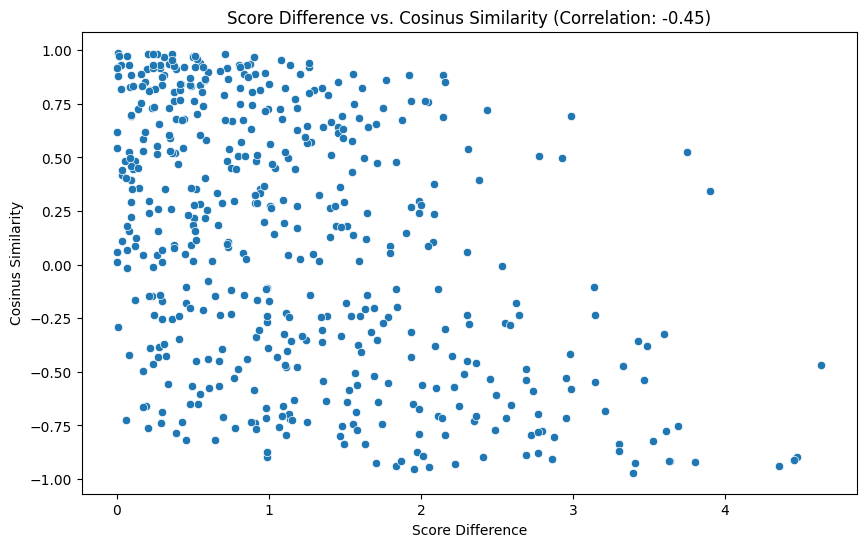

In [32]:
# Visualisation des rapport entre scores_diff et cos_sim
import matplotlib.pyplot as plt
import seaborn as sns

correlation = results_df['content_diff'].corr(results_df['cosine_similarity'])


plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_diff', y='cosine_similarity', data=results_df)

plt.title(f'Score Difference vs. Cosinus Similarity (Correlation: {correlation:.2f})')
plt.xlabel('Score Difference')
plt.ylabel('Cosinus Similarity')

plt.show()


---

## 6️⃣ Combiner les deux réponses

In [34]:
# Extraire les textes de R et R*, les convertir en format JSON

# Extraction
good_answer_text = r_star['text'].iloc[0]
random_answer_text = r_random['text'].iloc[0]

# Conversion des textes en format JSON
combined_Rs = f'''{{
    "A": "{good_answer_text}",
    "B": "{random_answer_text}"
}}'''


In [35]:
combined_Rs

'{\n    "A": "The third wave was an experiment that Ron Jones conducted as a social experiment at Cubberley High school in Palo Alto, CA. This lasted only five days because it got very out of control and developed way too fast.  originally, Jones stated he was starting a movement to illuminate democracy. The third wave was a symbol of strength. The movement went from 30 participants to 44 on the first day , he taught the students how to initiate new members, and by the end of the day there were over 200 members. The students were all very loyal to Jones,   "Jones was surprised that some of the students started reporting to him when other members of the movement failed to abide by the rules" This was a sign to him that students would do anything for power, and to move up and get superior to other students. He knew something must be done. The  experiment ended because people took this very srriously and they were very loyal to this and this was the students developing ba sense of superio

In [36]:
api_key = getpass('OpenAI API key: ')

OpenAI API key: ········


In [37]:
os.environ["OPENAI_API_KEY"] = api_key

client = OpenAI()

In [40]:

# utiliser json pour former le prompt
texts = combined_Rs

completion = client.chat.completions.create(
  model="gpt-3.5-turbo-0301",
  messages=[
    {"role": "system", "content": 
     "Given 2 texts: A and B in a json format . You need to intergrate the key points of A into B without changing too much B's content, in order to return a new text."},
    {"role": "system", "content": 
     "The length of the new text created should be less than the sum of the lengths of two texts. Your output should be in a correct json format, with the key 'combined_text' and the value as the new text."},
    {"role": "system", "content": 
     "You should focus on the contenu"},
    {"role": "user", 
     "content": texts}
  ],
    temperature=0.3
    )
# print(completion.choices[0].message)
# print(dict(completion).get('usage'))

retour = completion.model_dump_json(indent=2)
retour_json = json.loads(retour)
retour_texte = json.loads(retour_json['choices'][0]['message']['content'])["combined_text"]

In [41]:
print(retour_texte)

Once he gave control to the kids they took it and ran with it. The third wave was an experiment that Ron Jones conducted as a social experiment at Cubberley High school in Palo Alto, CA. This lasted only five days because it got very out of control and developed way too fast. Originally, Jones stated he was starting a movement to illuminate democracy. The third wave was a symbol of strength. The movement went from 30 participants to 44 on the first day, he taught the students how to initiate new members, and by the end of the day there were over 200 members. The students were all very loyal to Jones, 'Jones was surprised that some of the students started reporting to him when other members of the movement failed to abide by the rules.' This was a sign to him that students would do anything for power, and to move up and get superior to other students. He knew something must be done. The experiment ended because people took this very seriously and they were very loyal to this and this wa

In [42]:
print(len(retour_texte))
print(len(texts))


1476
1584


In [43]:
# créer un enregistrement

stu_id= '000000ffffff'
prompt_id = 'def789'
text_test = retour_texte

data_4_test = {
    'student_id': [stu_id],
    'prompt_id': [prompt_id],
    'text': [text_test]
}

test_data = pd.DataFrame(data_4_test)
# Jusqu'à ici, on a combiné les deux réponses.

test_data

,student_id,prompt_id,text
0,000000ffffff,def789,Once he gave control to the kids they took it ...


---

## 7️⃣ Modélisation et prédiction

In [45]:
# Suppression des deux enregistrements du DataFrame pour éviter le surapprentissage

merged_df_featured = merged_df_featured.drop(r_star.index)
merged_df_featured = merged_df_featured.drop(r_random.index)
merged_df_featured.shape

(7163, 17)

In [50]:
import pickle


def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    
    tokens = [token.lower() for token in tokens]
    
    tokens = [token for token in tokens if token.isalnum()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


def extract_features_tfidf(texts):
    tfidf_vectorizer = TfidfVectorizer()
    
    features = tfidf_vectorizer.fit_transform(texts)
    with open('tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)
    
    return features

In [55]:
# importer les données
train_text = merged_df_featured.text
test_text = test_data.text
train_text

0       The third wave was an experimentto see how peo...
1       They would rub it up with soda to make the sme...
2       In Egypt, there were many occupations and soci...
3       The highest class was Pharaohs these people we...
4       The Third Wave developed  rapidly because the ...
                              ...                        
7160    They used all sorts of chemical concoctions to...
7161    The lowest classes are slaves and farmers slav...
7162               they sorta made people start workin...
7163    An ideal tragety has three elements that make ...
7164    The meat would smell sour but the would "rub i...
Name: text, Length: 7163, dtype: object

In [56]:
# pretraitement
pretraite_train_text = [preprocess_text(reponse) for reponse in train_text]
pretraite_text_text = [preprocess_text(reponse) for reponse in test_text]

In [57]:
train_tfidf_features = extract_features_tfidf(pretraite_train_text)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf_vectorizer = pickle.load(f)

test_tfidf_features = loaded_tfidf_vectorizer.transform(pretraite_text_text)

In [58]:
train_tfidf_features.shape

(7163, 11985)

In [59]:
test_tfidf_features.shape


(1, 11985)

In [61]:
target_labels = merged_df_featured[['content']]
X_train, X_test, y_train, y_test = train_test_split(train_tfidf_features, target_labels, test_size=0.1, random_state=42)

# X_train = train_tfidf_features
# y_train = target_labels

In [62]:
# entraînement
regressor = XGBRegressor()
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

In [63]:
mse = mean_squared_error(y_test, predictions)
print(f"mse: {mse}")

mse: 0.2913474277806825


In [66]:
# Prédire
new_predictions = regressor.predict(test_tfidf_features)
print(f"Predictions on new data: {new_predictions}")

Predictions on new data: [2.6601431]


---